In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# read in all the words
words = open('names.csv', 'r').read().splitlines()[1:]
print(len(words))
print(max(len(w) for w in words))
print(words[:8])
words_orig = words
words = [w.lower() for w in words_orig]
print(words[:8])
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['*'] = 0
#stoi[';'] = 39
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '*':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

69
29
['Albania,ALB,2014,7.21', 'Algeria,DZA,2014,6.75', 'Argentina,ARG,2014,2.88', 'Armenia,ARM,2014,5.24', 'Australia,AUS,2014,1.81', 'Austria,AUT,2014,1.95', 'Bangladesh,BGD,2014,3.77', 'Belgium,BEL,2014,1.69']
['albania,alb,2014,7.21', 'algeria,dza,2014,6.75', 'argentina,arg,2014,2.88', 'armenia,arm,2014,5.24', 'australia,aus,2014,1.81', 'austria,aut,2014,1.95', 'bangladesh,bgd,2014,3.77', 'belgium,bel,2014,1.69']
{1: ' ', 2: ',', 3: '.', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: 'a', 15: 'b', 16: 'c', 17: 'd', 18: 'e', 19: 'f', 20: 'g', 21: 'h', 22: 'i', 23: 'j', 24: 'k', 25: 'l', 26: 'm', 27: 'n', 28: 'o', 29: 'p', 30: 'r', 31: 's', 32: 't', 33: 'u', 34: 'v', 35: 'w', 36: 'x', 37: 'y', 38: 'z', 0: '*'}
39
torch.Size([1233, 8]) torch.Size([1233])
torch.Size([169, 8]) torch.Size([169])
torch.Size([141, 8]) torch.Size([141])
******** --> c
*******c --> o
******co --> l
*****col --> o
****colo --> m
***colom --> b
**colomb --> i
*colombi 

In [ ]:
torch.manual_seed(42); # seed rng for reproducibility

In [ ]:
import torch
import torch.nn as nn

class Linear(nn.Module):
    def __init__(self, fan_in, fan_out, bias=True):
        super(Linear, self).__init__()
        self.weight = nn.Parameter(torch.randn((fan_in, fan_out)) / fan_in**0.5)  # note: kaiming init
        if bias:
            self.bias = nn.Parameter(torch.zeros(fan_out))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        out = x @ self.weight
        if self.bias is not None:
            out += self.bias
        return out

class BatchNorm1d(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        super(BatchNorm1d, self).__init__()
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        # Buffers (trained with a running 'momentum update')
        self.register_buffer('running_mean', torch.zeros(dim))
        self.register_buffer('running_var', torch.ones(dim))

    def forward(self, x):
        # Calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)  # Batch mean
            xvar = x.var(dim, keepdim=True)  # Batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Embedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, IX):
        return self.embedding(IX)

class FlattenConsecutive(nn.Module):
    def __init__(self, n):
        super(FlattenConsecutive, self).__init__()
        self.n = n

    def forward(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        return x

class Sequential(nn.Module):
    def __init__(self, layers):
        super(Sequential, self).__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Definition of the Tanh class
class Tanh(nn.Module):
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

import torch
import torch.nn as nn

# ... (the rest of your code)

class ReLU(nn.Module):
    def forward(self, x):
        return torch.relu(x)

# Now, you can create the model with ReLU activation
#n_embd = 30
#n_hidden = 512
#model = Sequential([
#    Embedding(vocab_size, n_embd),
#    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), ReLU(),
#    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), ReLU(),
#    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), ReLU(),
#    Linear(n_hidden, vocab_size),
#])


# Now, you can create the model as before
#n_embd = 30
#n_hidden = 512
#model = Sequential([
#    Embedding(vocab_size, n_embd),
#    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#    Linear(n_hidden, vocab_size),
#])


In [ ]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define your custom layers here

# Define the model using the custom layers
class CustomModel(nn.Module):
    def __init__(self, vocab_size, n_embd, n_hidden):
        super(CustomModel, self).__init__()
        # Create your model architecture using the custom layers
        self.model = Sequential([
            Embedding(vocab_size, n_embd),
            FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, vocab_size),
        ])

    def forward(self, x):
        return self.model(x)

# Initialize the model
n_embd = 30
n_hidden = 512
model = CustomModel(vocab_size, n_embd, n_hidden)

# Parameter initialization
with torch.no_grad():
    model.model.layers[-1].weight *= 0.1  # Last layer make less confident

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")
model.to(device)

# Convert data to GPU
Xtr = Xtr.to(device)
Ytr = Ytr.to(device)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001)
# Define the L2 regularization strength
#weight_decay = 1e-3

# Define the optimizer with weight decay (L2 regularization)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Same optimization as last time
max_steps = 200000
batch_size = 128
lossi = []

for i in range(max_steps):
    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]  # Batch X,Y

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update: simple SGD
    lr = 0.0001 if i < 150000 else 0.001  # Step learning rate decay
    optimizer.step()

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

'''for i in range(max_steps):
    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]  # Batch X,Y

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # L2 regularization (weight decay)
    l2_regularization = 0.0
    for param in model.parameters():
        l2_regularization += torch.norm(param, p=2) ** 2

    loss += weight_decay * l2_regularization

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update: simple SGD
    lr = 0.001 if i < 150000 else 0.01  # Step learning rate decay
    optimizer.step()

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())'''


Training on device: cuda
      0/ 200000: 3.6702
  10000/ 200000: 2.0494
  20000/ 200000: 1.6728
  30000/ 200000: 1.5162
  40000/ 200000: 1.4699
  50000/ 200000: 1.3895
  60000/ 200000: 1.2848
  70000/ 200000: 1.1982
  80000/ 200000: 1.2678
  90000/ 200000: 1.0200
 100000/ 200000: 1.0858
 110000/ 200000: 0.7860
 120000/ 200000: 0.6583
 130000/ 200000: 0.7418
 140000/ 200000: 0.6952
 150000/ 200000: 0.5850
 160000/ 200000: 0.6808
 170000/ 200000: 0.5835
 180000/ 200000: 0.4978
 190000/ 200000: 0.5803
CPU times: user 10min 1s, sys: 9.58 s, total: 10min 11s
Wall time: 10min 20s


'for i in range(max_steps):\n    # Minibatch construction\n    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)\n    Xb, Yb = Xtr[ix], Ytr[ix]  # Batch X,Y\n\n    # Forward pass\n    logits = model(Xb)\n    loss = F.cross_entropy(logits, Yb)\n\n    # L2 regularization (weight decay)\n    l2_regularization = 0.0\n    for param in model.parameters():\n        l2_regularization += torch.norm(param, p=2) ** 2\n\n    loss += weight_decay * l2_regularization\n\n    # Backward pass\n    optimizer.zero_grad()\n    loss.backward()\n\n    # Update: simple SGD\n    lr = 0.001 if i < 150000 else 0.01  # Step learning rate decay\n    optimizer.step()\n\n    # Track stats\n    if i % 10000 == 0:\n        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")\n    lossi.append(loss.log10().item())'

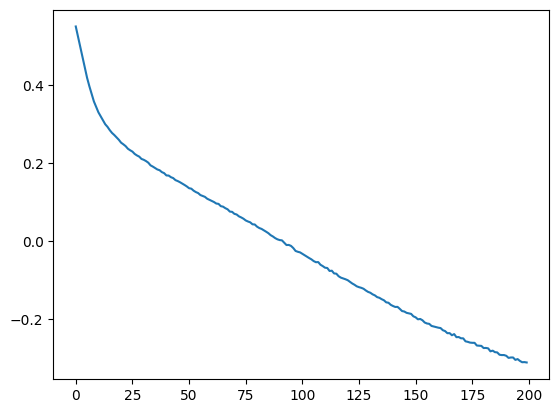

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
model.eval()

CustomModel(
  (model): Sequential(
    (layers): ModuleList(
      (0): Embedding(
        (embedding): Embedding(39, 30)
      )
      (1): FlattenConsecutive()
      (2): Linear()
      (3): BatchNorm1d()
      (4): Tanh()
      (5): FlattenConsecutive()
      (6): Linear()
      (7): BatchNorm1d()
      (8): Tanh()
      (9): FlattenConsecutive()
      (10): Linear()
      (11): BatchNorm1d()
      (12): Tanh()
      (13): Linear()
    )
  )
)

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr.to(device), Ytr.to(device)),
    'val': (Xdev.to(device), Ydev.to(device)),
    'test': (Xte.to(device), Yte.to(device)),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.4822658598423004
val 2.0276665687561035


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


## Save Model

In [ ]:
# Save the model to a file
checkpoint_path = 'model.pth'
torch.save(model.state_dict(), checkpoint_path)

In [ ]:
# Assuming you have loaded the model as shown in the previous response
# and put it into evaluation mode using model.eval()

# Sample from the model
for _ in range(50):
    out = []
    context = [0] * block_size  # initialize with all ...

    with torch.no_grad():
        while True:
            # Convert the context to a tensor and transfer it to the device
            context_tensor = torch.tensor([context])
            context_tensor = context_tensor.to(device)  # Assuming 'device' is properly defined

            # Forward pass the neural net
            logits = model(context_tensor)
            probs = F.softmax(logits, dim=1)

            # Sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()

            # Shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)

            # If we sample the special '.' token, break
            if ix == 0:
                break

    generated_text = ''.join(itos[i] for i in out)  # Decode the generated word
    #print(len(set(out)))
    print(generated_text.replace("*",""))  # Print the generated text for each iteration


ghana,nip,2014,3.01
sgarkigt2ur,t4hsri4,tza,2014,8.22
camhrd,2014,2.25
niswza0,mhy,2014,1.61
finland,tun,2014,3.09
netuna,yve,2014,3.04
rbenin,ben,2014,6.79
ningarb,nun,2014,7.45
bilevhn,7ss,2014,1.7
unitoz ugastan, rz,2014,1.63
madedosia,muc,2014,3.01
tania,mzu,2014,2967
golen,awr,2014,1.61
ireland,pol,28143
turvsies,urj,2014,1.51
kazakr6ua,spa,2014,1.77
colomdia,wte,2014,5.26
ireunicarls,r4a,2014,4.5b
netherlands,ret,2016
polane,pod,2014,2.41
tolzay,arw,2014,1.21
nicaigaroi,ala,27n4,2o8,2014,6.75
pain,esu,2014,1.61
united kin8dnm,gte,2014,6.76
united kingdom,gbr,2014,6.69
belgium,bel,2014,1.75
kerea,apa,2014,2.81
kerbedg7rm,hun,2014,
fuswchita6polanda,old,2014,1.79
poland,pol,2014,2.26
alo
aritedis,6hk,2014,1.71
unitray,uni,2014,1.61
mawy,orm,2014,1.8
peru,per,2014,1.77
sortoulg3ra,cal,2014,6.22
moldajis,edg,201o,3.81
honduras,ugd,2014,1.46
ma5ana,mdl,2014,1.73
pola,4mhl,bgl,2014,1.71
nesthhslas,gbn,207za7
honduras,unn6anndnanda,alg,2014,1.81
pelunder,etun,n.k,2014,1.8
norea,anc,2014


## load the saved model

In [ ]:
%pip install dill
import dill

# Save the model using dill.dump
with open('model.pkl', 'wb') as f:
    dill.dump(model, f)

# Load the model using dill.load
with open('model.pkl', 'rb') as f:
    loaded_model = dill.load(f)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
loaded_model.state_dict()

OrderedDict([('model.layers.0.embedding.weight',
              tensor([[ 1.9180,  1.4933,  0.9032,  ...,  1.3291, -0.2335,  0.0390],
                      [-0.2504,  0.8603, -1.3828,  ...,  0.0356, -0.0647,  0.6762],
                      [-0.1015,  1.8573, -1.1953,  ...,  0.0551,  0.7472, -0.4910],
                      ...,
                      [ 1.1901,  1.4109,  0.7956,  ..., -0.7785, -0.4175,  1.1048],
                      [ 0.2514, -0.1120,  0.7708,  ..., -0.4358, -0.0149,  0.5450],
                      [ 0.1230, -0.8732,  1.2215,  ...,  1.0107, -0.6509,  1.4622]],
                     device='cuda:0')),
             ('model.layers.2.weight',
              tensor([[ 0.1197,  0.1037,  0.0253,  ...,  0.1514, -0.0193, -0.1821],
                      [ 0.1055, -0.1113, -0.0813,  ..., -0.2518, -0.2264,  0.0434],
                      [-0.1263, -0.0099,  0.0871,  ..., -0.0185, -0.0673, -0.1473],
                      ...,
                      [-0.0059, -0.0127, -0.0804,  ...,  0.08

In [ ]:
# Assuming you have loaded the model as shown in the previous response
# and put it into evaluation mode using model.eval()

# Sample from the model
for _ in range(50):
    out = []
    context = [0] * block_size  # initialize with all ...

    with torch.no_grad():
        while True:
            # Convert the context to a tensor and transfer it to the device
            context_tensor = torch.tensor([context])
            context_tensor = context_tensor.to(device)  # Assuming 'device' is properly defined

            # Forward pass the neural net
            logits = loaded_model(context_tensor)
            probs = F.softmax(logits, dim=1)

            # Sample from the distribution
            ix = torch.multinomial(probs, num_samples=1).item()

            # Shift the context window and track the samples
            context = context[1:] + [ix]
            out.append(ix)

            # If we sample the special '.' token, break
            if ix == 0:
                break

    generated_text = ''.join(itos[i] for i in out)  # Decode the generated word
    #print(len(set(out)))
    print(generated_text.replace("*",""))  # Print the generated text for each iteration


thsnitedu1akady,n01,20142
bbobinil,4mbia,cun,2014,1.73
nitedek,nga,2014,1.79
arkana,chr,2014,1.74
northigl,201
beninw,gen,2014,1.8y
iargandjdflani,2de,20ce,3.pal,xde,2s14y0.21,p0k87
unin,h5a,2014,6.22
mali,iti,2014,33w4
china,chl,2014,1.88
pawime,m,kzra281tan,kdug2nm,fd,222,2014,3.01
bolgaria,bya,2014,1.75
argentura,den,2014,3.24
bolia,ihm,ns,52014,1.99
switzerlan,syn,2014,1.56
stmbra,2s14,2.4
portugakmaga,1tu,2014,3.88
switer,l0is,1.19
gbunimedvn s593d2fia,upa,2014,5.25
swtoemaia,gou,2014,3.88
poland,pol,2014,2.35
oolania,rrg,2014,3.24
lgarda,nld,2014,1.41
niusarbhn,,chs,2014,1.73
maakggytu0ktra,ph4,2014,3.75
arnica,cul,2014,1.75
united kin0dom,20ka,3
finland,nin,2014,1.92
costm rado,tni,2014,1.81
estonia,,4dux,1od,2014,2.01
sestenss,es n8,1rg,2014,2.98
vrloydom,2014,2.64
aunir,eug,2014,1.79
relosla,rdo,2014,4.25
colomda,cen,2014,3.33
hgaagesy,nin,2014,4.88
kkhes9mw,ige,2014,m.21
swoden,s.e,2014,1.58
ghatk ria, fr,2014,1.8
sthorla,,go922044j
swite,uss,2014,1.95
spain,tza,2014,3.81
etu